In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Custom functions 

In [90]:
import requests
import json
def get_pgs_anno_from_catalog(pgs_id: str) -> str | None:
    url = f'https://www.pgscatalog.org/rest/score/{pgs_id}'
    response = requests.get(url)
    anno = response.json()
    if 'trait_reported' in anno:
        return anno['trait_reported']
    elif 'description' in anno:
        return anno['description']
    else:
        return ''

def get_features_anno(df):
    return {
        col: get_pgs_anno_from_catalog(col.split('_')[0])
        for col in df.columns
    }

def top_n_corr_with_anno(X, y, n: int, plt_width=10, plt_height=6, file=None):
    corr = X.corrwith(y)
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(n).index
    top_features_names = [
        pgs.split('_')[0] + ' ' + get_pgs_anno_from_catalog(pgs.split('_')[0])
        for pgs in top_features
    ]
    plt.figure(figsize=(plt_width, plt_height))
    sns.barplot(x=abs_corr[top_features], y=top_features_names, color='darkorchid')
    plt.xlabel('Absolute Correlation with BMI', fontsize=14, fontweight='bold')
    plt.ylabel('Features', fontsize=14, fontweight='bold')
    plt.title(f'Top {n} Features Correlated with BMI', fontweight='bold')
    if file is not None:
        plt.savefig(file, bbox_inches='tight', format='pdf')
    plt.show()

def reduce_to_top_n_correlated(X, y, n):
    corr = X.corrwith(y)
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(n).index
    return X[top_features]

### Save PGS Meta information

In [91]:
def fetch_pgs_catalog_metadata(f='pgs_meta.json'):
    initial_url = 'https://www.pgscatalog.org/rest/score/all'
    full_meta = []

    url = initial_url
    page=1
    while url:
        print(f"Processing page {page}")
        response = requests.get(url)
        
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}")
            break
       
        data = response.json()
        scores = data.get('results', [])
        full_meta.extend(scores)
    
        if 'next' in data and data['next']:
            page+=1
            url = data.get('next')
        else:
            break  # No more pages, exit the loop
    print(f"Total number of scores fetched: {len(full_meta)}")
    return full_metam

# meta = fetch_pgs_catalog_metadata()
# with open('pgs_meta.json', 'w') as f:
#     json.dump(meta, f)

### Local Metadata functions 

In [92]:
def read_pgs_meta(file='pgs_meta.json'):
    with open(file, 'r') as f:
        meta = json.load(f)
        return meta

def get_id_trait_dict(meta=None):
    if meta is None:
        meta = read_pgs_meta()
    id_trait = {}
    for pgs in meta:
        id_trait[pgs.get('id')] = pgs.get('trait_reported')
    return id_trait

def get_pgs_trait(pgs_id):
    meta = get_id_trait_dict()
    return meta[pgs_id]

def annot_pgs_cols(df):
    meta = get_id_trait_dict()
    anno = {}
    for col in list(df.columns):
        pgs = col.split('_')[0]
        if pgs.startswith('PGS'):
            anno[col] = meta[pgs]
    return anno

In [54]:
get_pgs_trait('PGS003959')

'Obesity'

# Analysis

In [93]:
df_orig = pd.read_csv('merged_avg.csv')

/tmp/ipykernel_101476/1824097721.py:1: DtypeWarning: Columns (0,4034) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv('merged_avg.csv')


In [3]:
df.head()

IID  PGS000004_hmPOS_GRCh37  PGS000005_hmPOS_GRCh37  \
0  1111111                0.012663                0.012663   
1  1111112                0.006850                0.006850   
2  1111113                0.024463                0.024463   
3  1111114                0.000000                0.000000   
4  1111115                0.000000                0.000000   

   PGS000006_hmPOS_GRCh37  PGS000007_hmPOS_GRCh37  PGS000008_hmPOS_GRCh37  \
0                0.012663                0.003417                0.003417   
1                0.006850                0.002429                0.002429   
2                0.024463                0.003096                0.003096   
3                0.000000                0.001754                0.001754   
4                0.000000                0.001375                0.001375   

   PGS000009_hmPOS_GRCh37  PGS000011_hmPOS_GRCh37  PGS000012_hmPOS_GRCh37  \
0                0.003417                0.060004                0.007639   
1                0.002429                0.038459                0.007835   
2                0.003096                0.000000                0.007036   
3                0.001754                0.016915                0.007303   
4                0.001375                0.038459                0.007526   

   PGS000014_hmPOS_GRCh37  ...  height   age  sex        bmi  ethnicity  \
0                0.000004  ...   170.0  48.0    M  24.913495        Rus   
1                0.000004  ...   182.0  46.0    M  30.189591        Rus   
2                0.000004  ...   180.0  57.0    M  33.024691        Rus   
3                0.000004  ...   158.0  34.0    F  21.230572        Rus   
4                0.000005  ...   168.0  31.0    F  17.715419        Rus   

       source  zscore_BMI_clasters  zscore_height_clasters  \
0  this study            -0.734554               -1.352854   
1  this study             0.477736                0.460751   
2  this study             1.129158                0.158484   
3  this study            -0.847469               -1.268454   
4  this study            -1.495959                0.417866   

   PRS_by_claters_height  PRS_by_claters_bmi  
0               0.000444           -0.000179  
1               0.000130           -0.000115  
2               0.000175           -0.000065  
3               0.000147           -0.000001  
4               0.000244           -0.000011  

[5 rows x 4047 columns]

In [94]:
useless_columns = ['ID', 'clusters', 'weight', 'height', 'ethnicity',
       'source', 'zscore_BMI_clasters', 'zscore_height_clasters',
       'PRS_by_claters_height', 'PRS_by_claters_bmi', 'IID', ]
df = df_orig.drop(useless_columns, axis=1)
df_sex = pd.get_dummies(df, columns=['sex'], drop_first=True)
df = df.drop(['sex', 'age'], axis=1)

### EDA

In [95]:
X = df.drop(columns=['bmi'])
y = df['bmi']

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


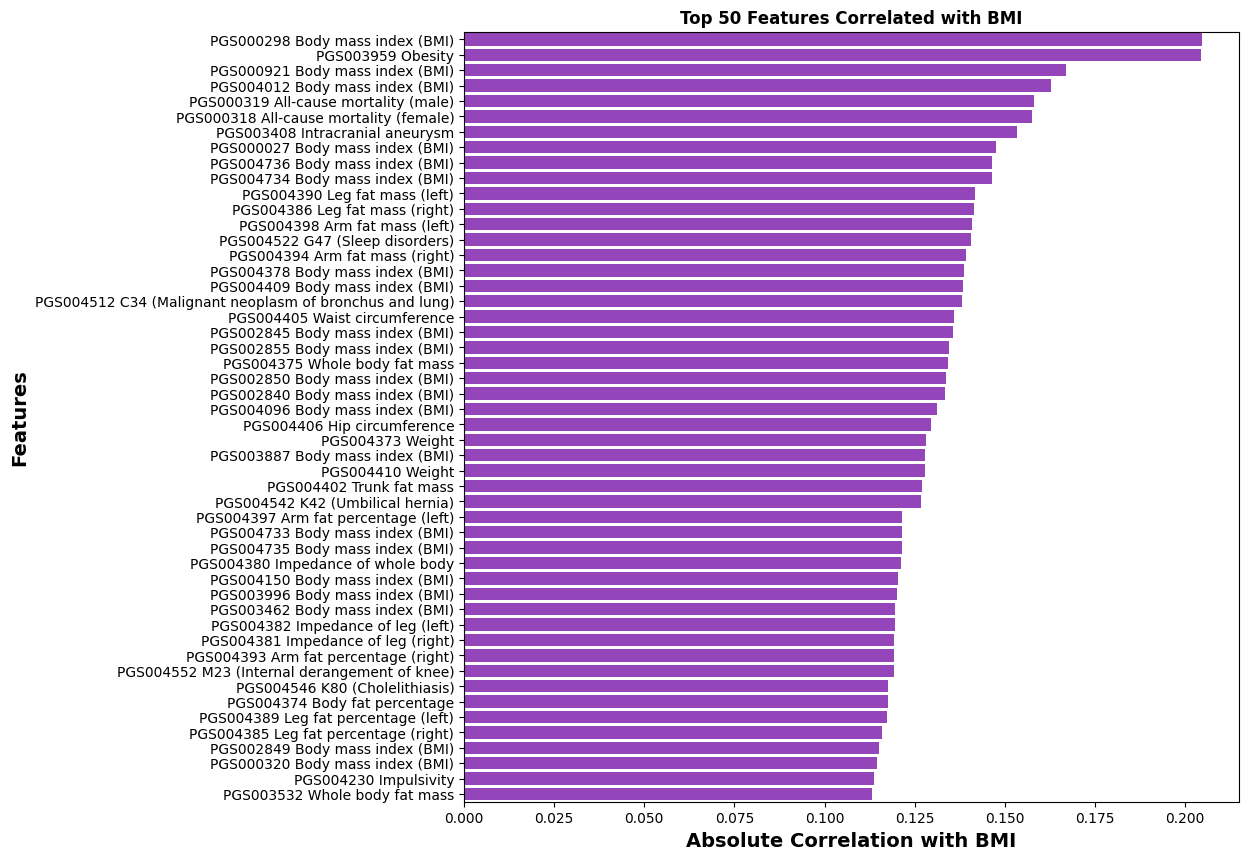

In [76]:
top_n_corr_with_anno(X, y, 50, plt_width=10, plt_height=10, file='top_50_corr.pdf')

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


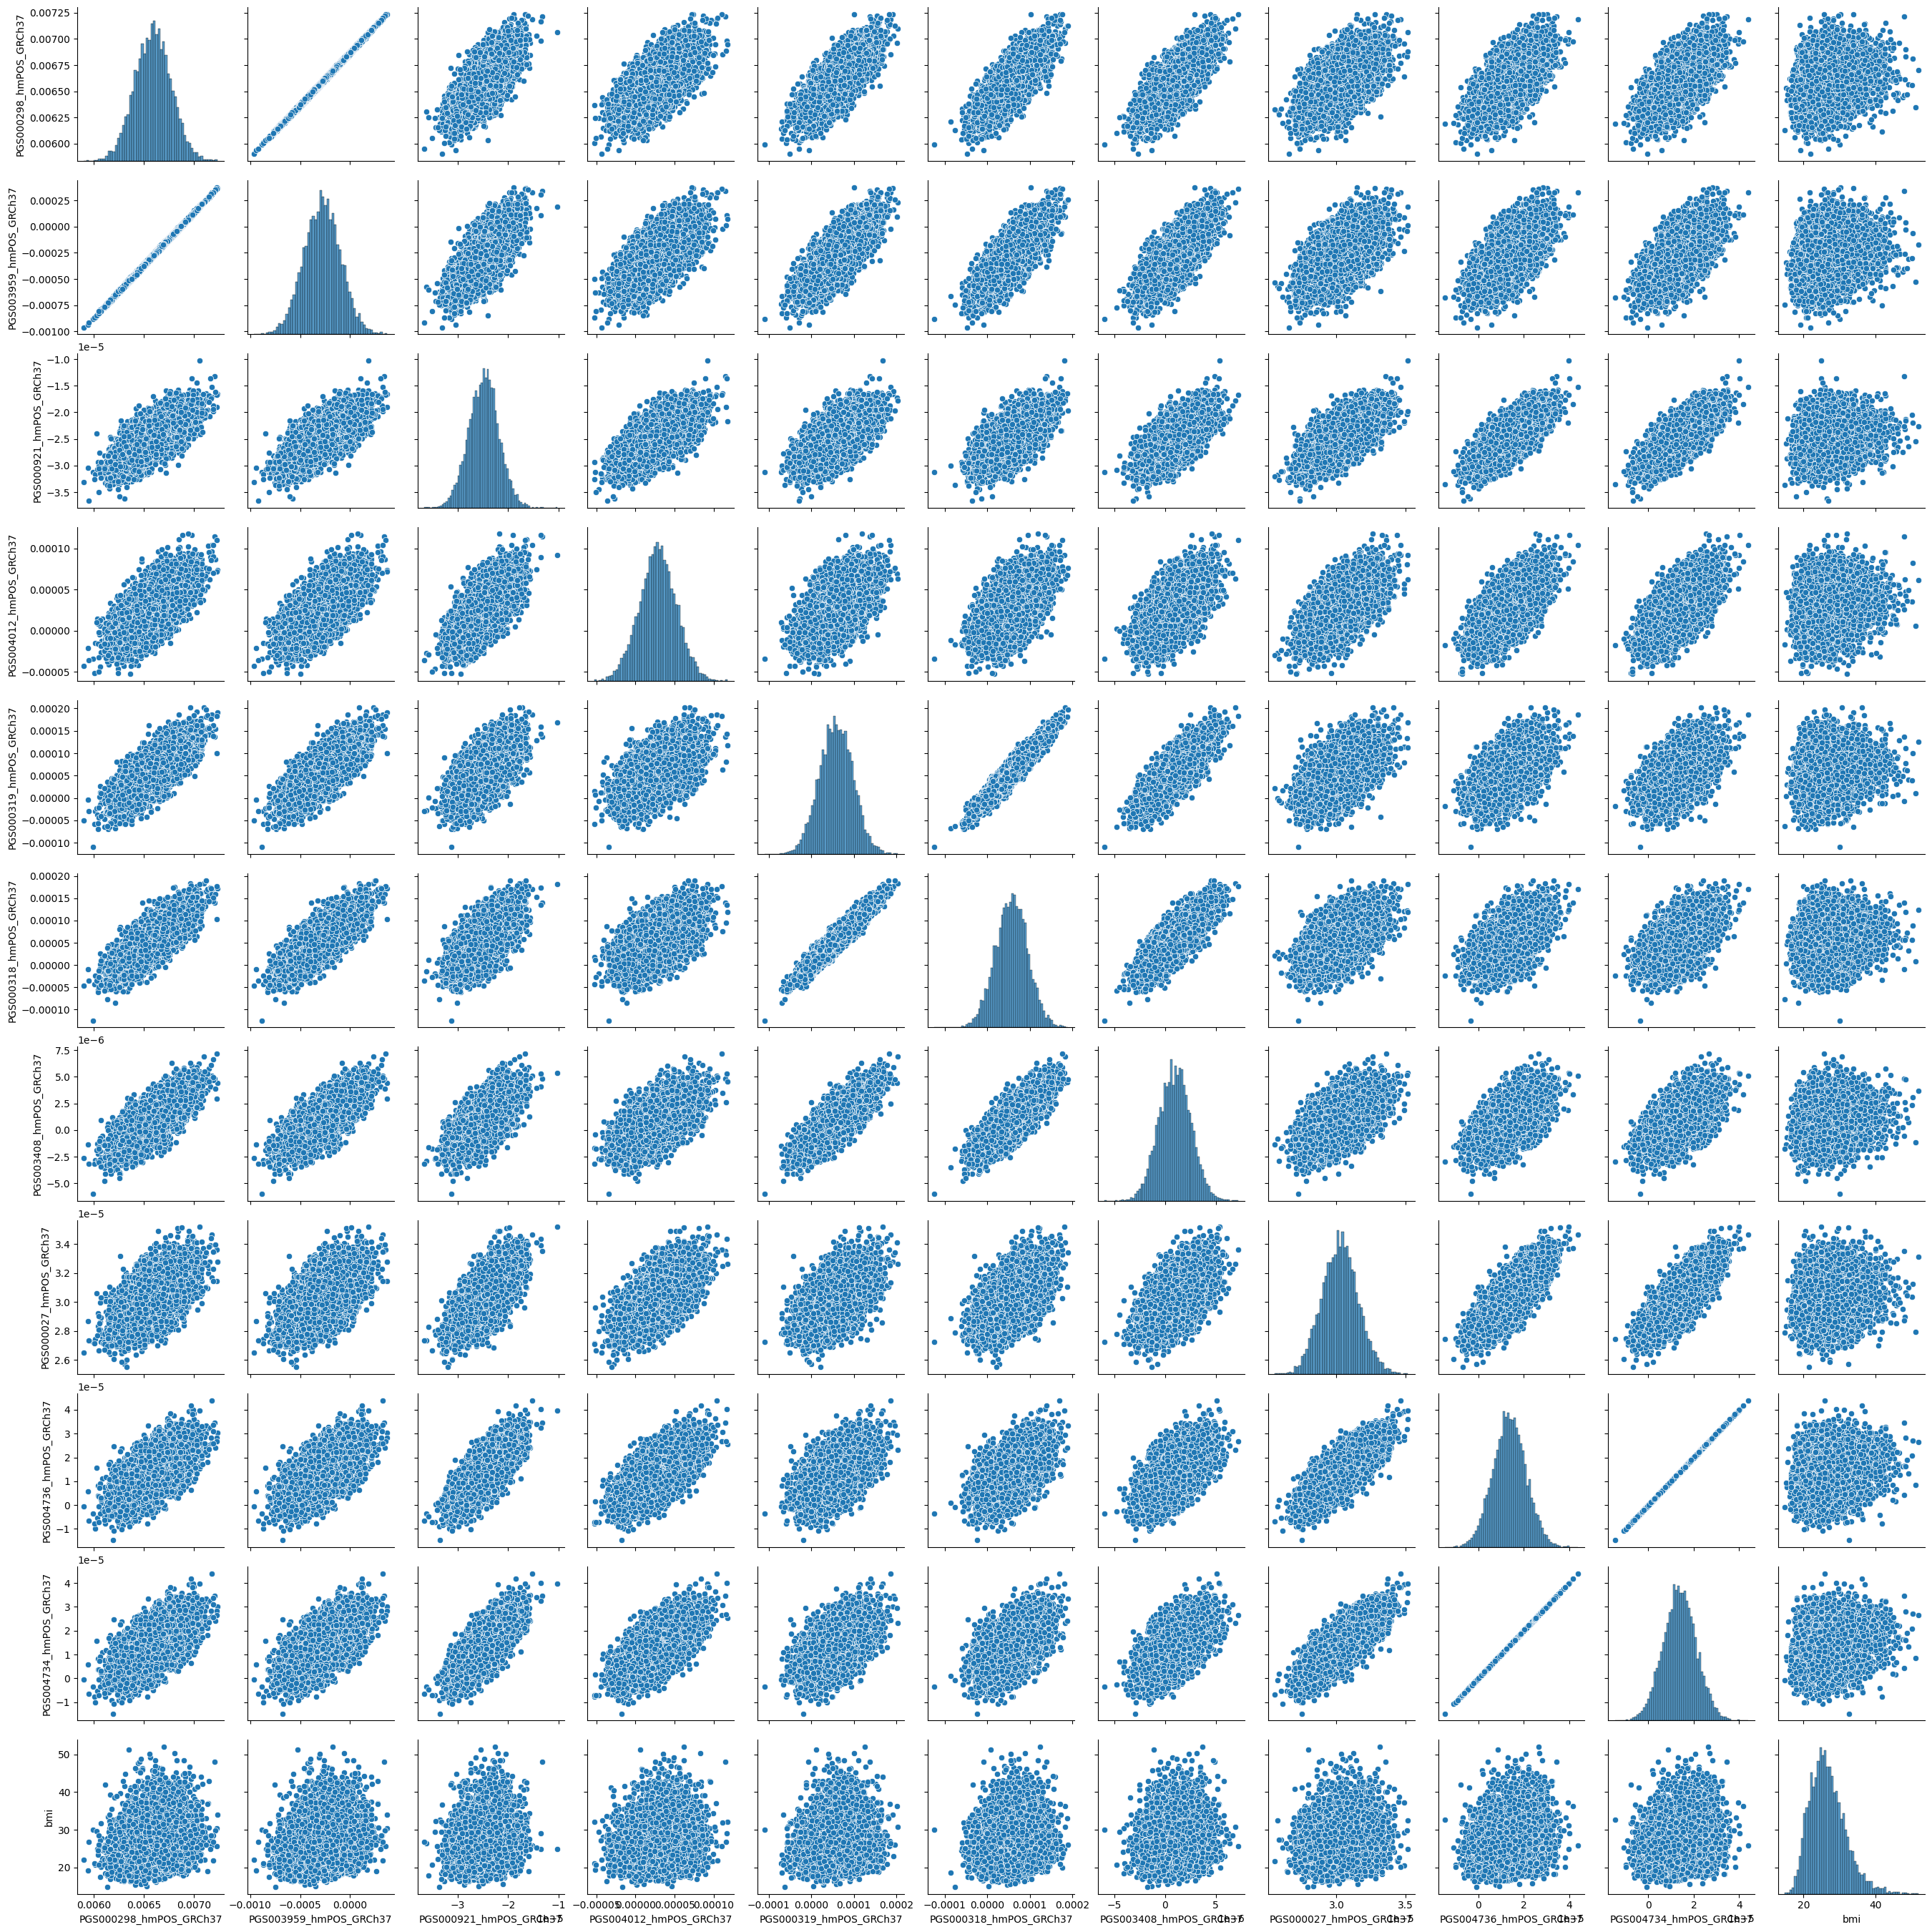

In [82]:
top_10 = reduce_to_top_n_correlated(X, y, 10)
sns.pairplot(df[list(top_10.columns) + ['bmi']])

In [96]:
top_1 = reduce_to_top_n_correlated(X, y, 1)

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


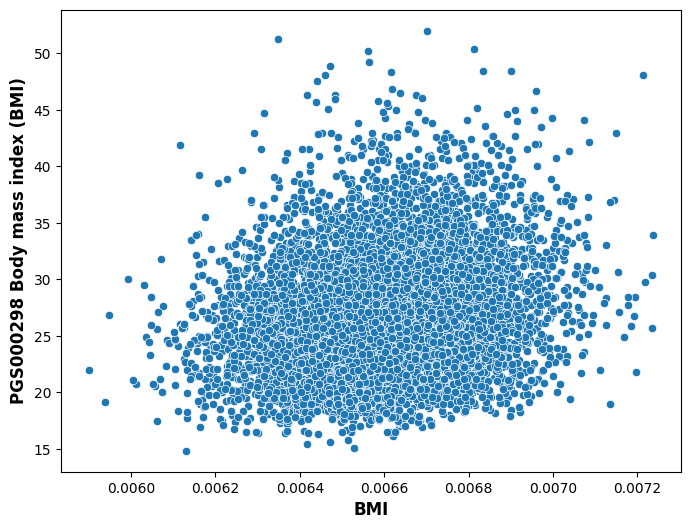

In [98]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PGS000298_hmPOS_GRCh37', y='bmi', data=df)
plt.xlabel('BMI', fontsize=12, fontweight='bold')
plt.ylabel('PGS000298 Body mass index (BMI)', fontsize=12, fontweight='bold')
plt.savefig('top_1_corr_scatter.pdf', bbox_inches='tight', format='pdf')

### Try with sex 

In [54]:
top_n = list(reduce_to_top_n_correlated(X, y, 100).columns)
features = top_n + ['sex_M', 'age']

X = df_sex[features]
y = df_sex['bmi']

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, n_jobs=-1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [15]:
print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost Mean Squared Error: 21.65144849910958
XGBoost R-squared: 0.06850972766034968


### Remove all BMI PGS 

In [63]:
top_n_df = reduce_to_top_n_correlated(df_sex.drop(['sex_M', 'bmi', 'age'], axis=1), y, 300)
anno = annot_pgs_cols(top_n_df)
no_bmi = {pgs: an for pgs, an in anno.items() if 'bmi' not in an.lower()}
no_bmi = list(no_bmi.keys())
len(no_bmi)

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


235

In [64]:
X_no_bmi = df_sex[no_bmi + ['sex_M', 'age']]
y = df_sex['bmi']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_bmi)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [42]:
xgb_model = xgb.XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost Mean Squared Error: 20.22129963110599
XGBoost Root Mean Squared Error: 4.496809939402152
XGBoost R-squared: 0.13003770157847783


#### Try GridSearch 

In [65]:
model = xgb.XGBRFRegressor(n_jobs=-1, random_state=42)
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score: {best_score}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
Best R-squared Score: 0.06142288951332651


In [33]:
y_pred_xgb = grid_search.best_estimator_.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost R-squared: 0.053487218349604126


In [87]:
X_bmi = df_sex[list(top_n_df.columns) + ['sex_M', 'age']]
y = df_sex['bmi']

X_bmi.shape

(8554, 302)

In [88]:
X_scaled = scaler.fit_transform(X_bmi)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score: {best_score}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
Best R-squared Score: 0.06064700956525508
